# Setup File

Import libraries

In [1]:
import os
import shutil
import zipfile
import pickle
import re
import csv
import pandas as pd
import numpy as np
from scipy.signal import butter, lfilter, freqz
import scipy.signal as sg

import matplotlib.pyplot as plt
%matplotlib inline


import scipy as sp
from scipy import signal

Create folders in which to save processed data

In [2]:
#Path to the different folders
data_path = 'data'
temp_path = data_path + '/temp'
backup_path = data_path + '/backup'

if not os.path.isdir(data_path):
    os.mkdir(data_path)
    os.mkdir(temp_path)
    os.mkdir(backup_path)

## Preprocessing of collected data

In [3]:
#File names for the angel and power data
a_data = 'Collected Data/' + '20_11_75_percent_path2_axis.txt' #The angle data 
p_data = 'Collected Data/' + '20_11_75_path2_percent_dat.csv' #The power data

Open joint angle data

In [4]:
with open(a_data, 'r') as file:
    try:
        data = file.read()
        file.close()
    except UnicodeDecodeError:
        file.close()
data = data.splitlines()
data = data[4:len(data)-1] #Text information on first four rows and END on last row

data_dim = len(data[0].split()[1:])

traj_data = np.ndarray((len(data),data_dim))
for i, row in enumerate(data):
    traj_data[i] = np.array([float(n)*np.pi/180 for n in row.split()[1:]])

with open(data_path + '/joint_angle_data.pickle', 'wb') as file:
    pickle.dump(traj_data, file)
    file.close()

Open voltage and current data

In [5]:
f = open(p_data)

data = []
for line in f:
    data_line = line.rstrip().split('\t')
    data.append(data_line)

init=True
for i, file in enumerate(data[9:]):
    file = file[0].replace(',','.')
    file = file.replace(' ','')
    if init:
        Volt_Amp_data = np.ndarray((len(data),len(file.split(';'))-1))
        init=False
    Volt_Amp_data[i] = np.array([float(n) for n in file.split(';')[:len(file.split(';'))-1]])

Calculate momentaneous power form voltage/current measurements

In [6]:
n_phases   = 3   #Number of phases in measured data
power_data = np.ndarray((len(Volt_Amp_data),1))
power_time = np.ndarray((len(Volt_Amp_data),1))
amp_data   = np.ndarray((len(Volt_Amp_data),n_phases))
volt_data  = np.ndarray((len(Volt_Amp_data),n_phases))

for i, sample in enumerate(Volt_Amp_data):
    power_time[i] = sample[0]
    volt_data[i]  = np.array([sample[1], sample[2], sample[3]])
    amp_data[i]   = np.array([sample[4], sample[5], sample[6]])
    power_data[i] = np.abs(sample[1]*sample[4]) \
        + np.abs(sample[2]*sample[5]) \
        + np.abs(sample[3]*sample[6]) 


Plot

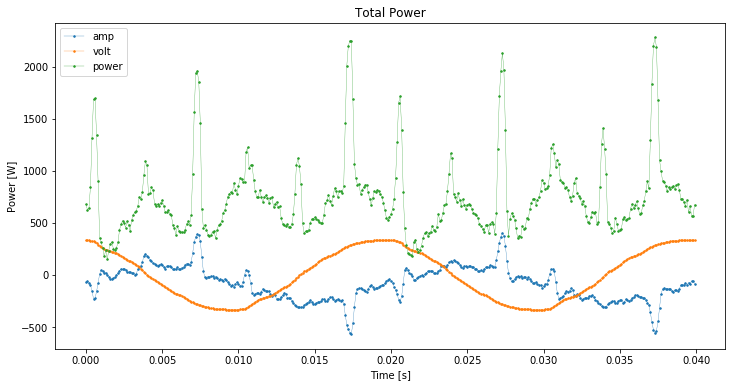

In [7]:
n_periods = 0 # Where to start the plot
period    = 200  # Number of samples in a period (Voltage_Current_sample_freq)/50Hz
interval  = 2    # Number of periods to be plotted
phase     = 0    # Which phase to be plotted (0 --> phase1, 1 --> phase2, 2 --> phase3)
amp_scale = 100  # Which factor to use to scale up the current data in the plot

plt.figure(figsize=(12,6))
fig = plt.subplot()
x = range(len(power_data))
fig.plot(power_time[n_periods*period:(n_periods+interval)*period], amp_data[n_periods*period:(n_periods+interval)*period,phase]*amp_scale,  label='amp',  marker='o',linewidth=0.3, markersize=1.5)
fig.plot(power_time[n_periods*period:(n_periods+interval)*period], volt_data[n_periods*period:(n_periods+interval)*period,phase],  label='volt',  marker='o',linewidth=0.3, markersize=1.5)
fig.plot(power_time[n_periods*period:(n_periods+interval)*period], power_data[n_periods*period:(n_periods+interval)*period],  label='power',  marker='o',linewidth=0.3, markersize=1.5)
fig.legend();
fig.set_ylabel('Power [W]')
fig.set_xlabel('Time [s]')
fig.set_title('Total Power');

Calculate moving average of momentaneous power (Downsampled to 250 Hz which is an even factor 3 times higher than angle sample frequecy). Moving average is taken at one period at a time so that the current spikes behaves similarly in every calculated average. That is why we also need to upsample a factor of 5 later.

In [8]:
fs_factor = 200 # Number of samples per period (Voltage_Current_sample_freq)/50Hz
power_data_moving_av = np.ndarray((len(range(fs_factor,len(volt_data),fs_factor))*5,1))
start = np.argmin(volt_data[0:200])

i=0
for j in range(start,len(power_data),fs_factor):
    power_data_moving_av[i:i+5] = np.mean(power_data[j:j+fs_factor])
    power_time_ds = power_time[start:len(power_time):40]
    i += 5
power_time_ds = power_time_ds[0:len(power_data_moving_av)]

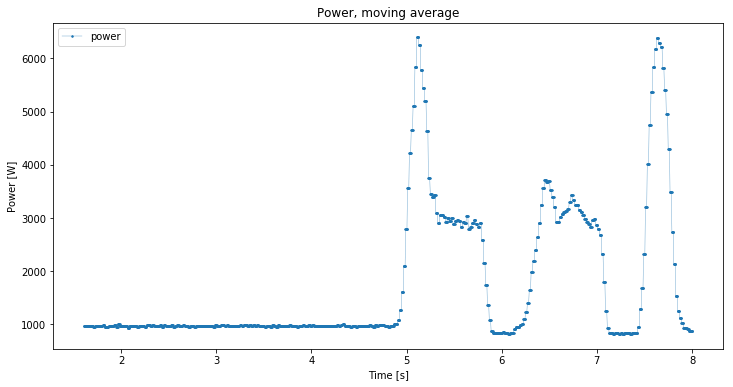

In [9]:
plt.figure(figsize=(12,6))
fig = plt.subplot()
x = range(len(power_data))
fig.plot(power_time_ds[400:2000], power_data_moving_av[400:2000],  label='power',  marker='o',linewidth=0.3, markersize=1.5)
fig.legend();
fig.set_ylabel('Power [W]')
fig.set_xlabel('Time [s]')
fig.set_title('Power, moving average');

Calculate velocity, acceleration and pseudopower

In [10]:
#Time vector for angle measurements (fixed in KUKA system)
delta_t = 0.012
t = np.ndarray((len(traj_data),1))
t[0] = 0
for i in range(1,len(traj_data)):
    t[i] = t[i-1] + delta_t

#Velocity 
vel = np.ndarray(np.shape(traj_data))
for i in range(len(traj_data)-1):
    vel[i] = np.divide( traj_data[i+1] - traj_data[i], delta_t)
vel[-1] = vel[-2]

#Acceleration
acc = np.ndarray(np.shape(traj_data))
for i in range(len(traj_data)-1):
    acc[i] = np.divide( vel[i+1] - vel[i], delta_t)
acc[-1] = acc[-2]

#Pseudopower
psi = np.ndarray((np.shape(traj_data)[0],1))
for i in range(len(traj_data)):
    psi[i] = np.sum(np.abs(vel[i]*acc[i]))

Upsample angle measurement data to 250 Hz

In [11]:
US = 3
traj_data_us = np.ndarray((len(traj_data)*US,6))
vel_us = np.ndarray(np.shape(traj_data_us))
acc_us = np.ndarray(np.shape(traj_data_us))
psi_us = np.ndarray((len(traj_data)*US,1))
j=0
for i, angles in enumerate(traj_data):
    traj_data_us[j:j+US] = traj_data[i]
    vel_us[j:j+US] = vel[i]
    acc_us[j:j+US] = acc[i]
    psi_us[j:j+US] = psi[i]
    j+=US
    
#Time vector for angle measurements (fixed in KUKA system)
delta_t = 0.012/US
t = np.ndarray((len(traj_data_us),1))
t[0] = 0
for i in range(1,len(traj_data_us)):
    t[i] = t[i-1] + delta_t

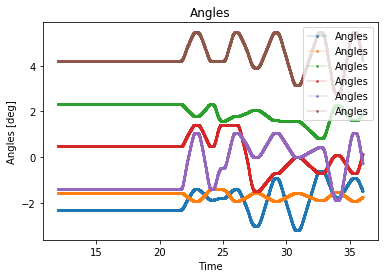

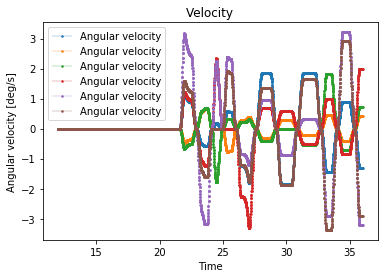

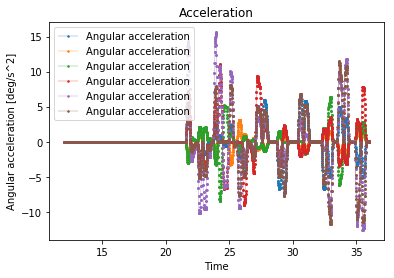

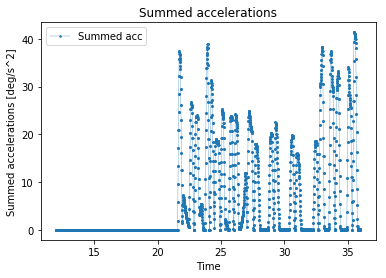

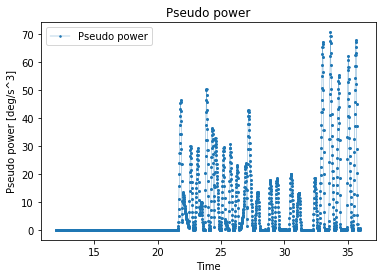

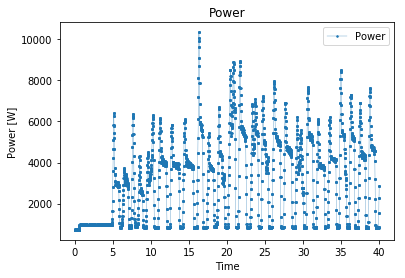

In [12]:
first, last = 3000, 9000 # Sample interval to plot

fig1, ax1 = plt.subplots()
ax1.plot(t[first:last], traj_data_us[first:last],  label='Angles',  marker='o',linewidth=0.3, markersize=1.5)
ax1.legend();
ax1.set_ylabel('Angles [deg]')
ax1.set_xlabel('Time')
ax1.set_title('Angles');

fig2, ax2 = plt.subplots()
ax2.plot(t[first:last], vel_us[first:last],  label='Angular velocity',  marker='o',linewidth=0.3, markersize=1.5)
ax2.legend();
ax2.set_ylabel('Angular velocity [deg/s]')
ax2.set_xlabel('Time')
ax2.set_title('Velocity');

fig3, ax3 = plt.subplots()
ax3.plot(t[first:last], acc_us[first:last],  label='Angular acceleration',  marker='o',linewidth=0.3, markersize=1.5)
ax3.legend();
ax3.set_ylabel('Angular acceleration [deg/s^2]')
ax3.set_xlabel('Time')
ax3.set_title('Acceleration');

fig4, ax4 = plt.subplots()
ax4.plot(t[first:last], np.sum(np.abs(acc_us[first:last]), axis=1),  label='Summed acc',  marker='o',linewidth=0.3, markersize=1.5)
ax4.legend();
ax4.set_ylabel('Summed accelerations [deg/s^2]')
ax4.set_xlabel('Time')
ax4.set_title('Summed accelerations');

fig5, ax5 = plt.subplots()
ax5.plot(t[first:last], psi_us[first:last],  label='Pseudo power',  marker='o',linewidth=0.3, markersize=1.5)
ax5.legend();
ax5.set_ylabel('Pseudo power [deg/s^3]')
ax5.set_xlabel('Time')
ax5.set_title('Pseudo power');

fig6, ax6 = plt.subplots()
ax6.plot(power_time_ds[0:10000], power_data_moving_av[0:10000],  label='Power',  marker='o',linewidth=0.3, markersize=1.5)
ax6.legend();
ax6.set_ylabel('Power [W]')
ax6.set_xlabel('Time')
ax6.set_title('Power');

### Find start of power measurements

Start at power sample: 1229  corresponding to time: [4.9248] sec
Start at trajectory sample: 5397  corresponding to time: [21.588] sec


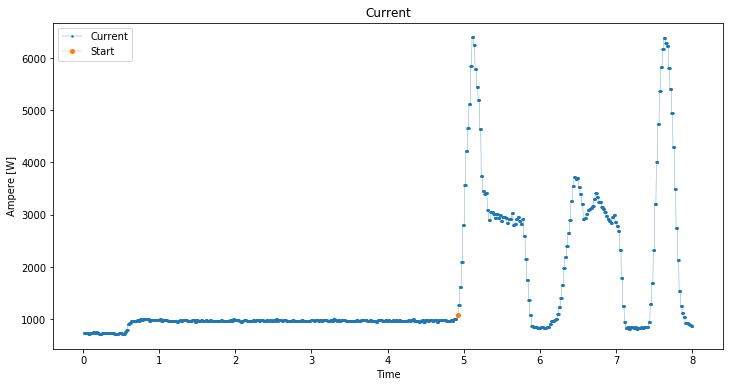

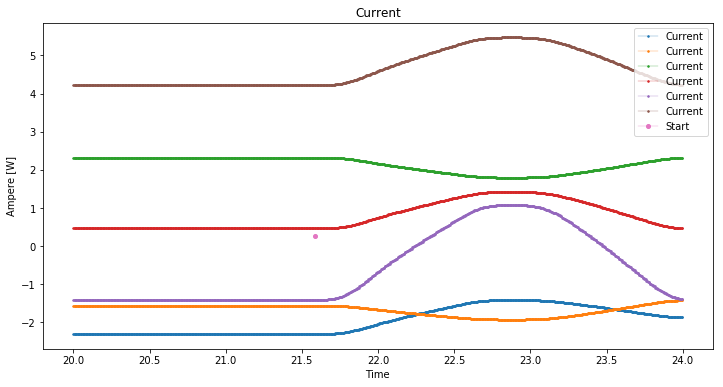

In [13]:
Start_power_indicator = 1200
for i in range(len(power_data_moving_av)):
    if np.max(np.abs(power_data_moving_av[i]))>Start_power_indicator:
        starting_point_power = i
        break
print('Start at power sample:',starting_point_power-1,' corresponding to time:',power_time_ds[starting_point_power-1],'sec')

Start_trajectory_indicator = 0
for i in range(len(traj_data_us)):
    if np.max(np.abs(acc_us[i]))>Start_trajectory_indicator:
        starting_point_traj = i
        break
print('Start at trajectory sample:',starting_point_traj,' corresponding to time:',t[starting_point_traj],'sec')


plt.figure(figsize=(12,6))
fig = plt.subplot()
fig.plot(power_time_ds[0:2000], power_data_moving_av[0:2000],  label='Current',  marker='o',linewidth=0.3, markersize=1.5)
fig.plot(power_time_ds[starting_point_power-1], power_data_moving_av[starting_point_power-1],  label='Start',  marker='o',linewidth=0.3, markersize=4)
fig.legend();
fig.set_ylabel('Ampere [W]')
fig.set_xlabel('Time')
fig.set_title('Current');

plt.figure(figsize=(12,6))
fig = plt.subplot()
fig.plot(t[5000:6000], traj_data_us[5000:6000],  label='Current',  marker='o',linewidth=0.3, markersize=1.5)
fig.plot(t[starting_point_traj], acc_us[starting_point_traj][0],  label='Start',  marker='o',linewidth=0.3, markersize=4)
fig.legend();
fig.set_ylabel('Ampere [W]')
fig.set_xlabel('Time')
fig.set_title('Current');

In [14]:
#Align the data
traj_data_synced = traj_data_us[starting_point_traj:-1]
vel_synced = vel_us[starting_point_traj:-1]
acc_synced = acc_us[starting_point_traj:-1]
psi_synced = psi_us[starting_point_traj:-1]
power_data_synced = power_data_moving_av[starting_point_power-1:starting_point_power-1+len(traj_data_synced)]
t_synced = t[starting_point_traj:-1]

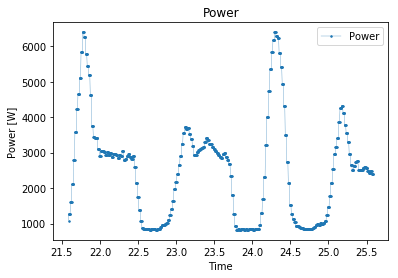

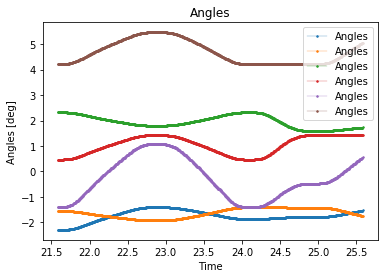

In [15]:
fig1, ax1 = plt.subplots()
ax1.plot(t_synced[0:1000], power_data_synced[0:1000],  label='Power',  marker='o',linewidth=0.3, markersize=1.5)
ax1.legend();
ax1.set_ylabel('Power [W]')
ax1.set_xlabel('Time')
ax1.set_title('Power');

fig2, ax2 = plt.subplots()
ax2.plot(t_synced[0:1000], traj_data_synced[0:1000],  label='Angles',  marker='o',linewidth=0.3, markersize=1.5)
ax2.legend();
ax2.set_ylabel('Angles [deg]')
ax2.set_xlabel('Time')
ax2.set_title('Angles');

### Augment the input vector and save

In [16]:
with open(data_path + '/power_data.pickle', 'wb') as file:
    pickle.dump(power_data_synced, file)
    file.close()

#Create the augmented input vector containing [angle1,..,angle6, vel1,..,vel6, acc1,..,acc6, psi] for all timesteps.

aug_feature_dim = 19
aug_input = np.ndarray((len(t_synced),aug_feature_dim))

for i in range(len(t_synced)):
    aug_input[i] = np.concatenate((traj_data_synced[i], vel_synced[i], acc_synced[i], psi_synced[i]), axis=None)

with open(data_path + '/augmented_input.pickle', 'wb') as file:
    pickle.dump(aug_input, file)
    file.close()

### Normalize input data within axis range

In [69]:
feature_dim = len(traj_data_synced[0])*3 + 1

aug_input_norm = np.ndarray((len(t_synced),feature_dim))
traj_data_norm = np.ndarray(np.shape(traj_data_synced))
vel_norm = np.ndarray(np.shape(vel_synced))
acc_norm = np.ndarray(np.shape(acc_synced))
psi_norm = np.ndarray(np.shape(psi_synced))

A1_constraint = [np.deg2rad(-185), np.deg2rad(185)]
A2_constraint = [np.deg2rad(-135), np.deg2rad(35)]
A3_constraint = [np.deg2rad(-120), np.deg2rad(158)]
A4_constraint = [np.deg2rad(-350), np.deg2rad(350)]
A5_constraint = [np.deg2rad(-119), np.deg2rad(119)]
A6_constraint = [np.deg2rad(-350), np.deg2rad(350)]

vel_max = 4.159647569601188
vel_min = -3.9450433392170803
acc_max = 27.338764681179683
acc_min = -28.319179147808107
psi_max = 126.43383111466377
psi_min = 0.0

constraints_min = [A1_constraint[0],A2_constraint[0],A3_constraint[0],A4_constraint[0],A5_constraint[0],A6_constraint[0]]
constraints_diff = [float(np.diff(A1_constraint)), float(np.diff(A2_constraint)),float(np.diff(A3_constraint)),float(np.diff(A4_constraint)),float(np.diff(A5_constraint)),float(np.diff(A6_constraint))]

vel_diff = vel_max - vel_min
acc_diff = acc_max - acc_min
psi_diff = psi_max - psi_min

for i in range(len(t_synced)):
    traj_data_norm[i] = 2*np.divide((traj_data_synced[i] - constraints_min),constraints_diff) - 1
    vel_norm[i] = 2*(vel_synced[i] - vel_min)/vel_diff - 1
    acc_norm[i] = 2*(acc_synced[i] - acc_min)/acc_diff - 1
    psi_norm[i] = psi_synced[i]/psi_diff    
    aug_input_norm[i] = np.concatenate((traj_data_norm[i], vel_norm[i], acc_norm[i], psi_norm[i]), axis=None)

with open(data_path + '/augmented_normalized_input.pickle', 'wb') as file:
    pickle.dump(aug_input_norm, file)
    file.close()

## Low pass filtering of power data (working example)

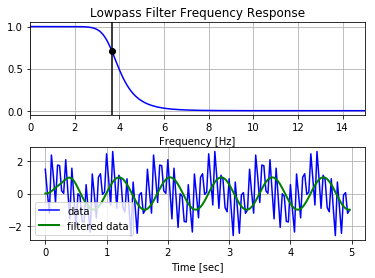

In [70]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 30.0       # sample rate, Hz
cutoff = 3.667  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()


# Demonstrate the use of the filter.
# First make some data to be filtered.
T = 5.0         # seconds
n = int(T * fs) # total number of samples
t = np.linspace(0, T, n, endpoint=False)
# "Noisy" data.  We want to recover the 1.2 Hz signal from this.
data = np.sin(1.2*2*np.pi*t) + 1.5*np.cos(9*2*np.pi*t) + 0.5*np.sin(12.0*2*np.pi*t)

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, cutoff, fs, order)

plt.subplot(2, 1, 2)
plt.plot(t, data, 'b-', label='data')
plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
